1.Problem overview

In [2]:
%pwd

'C:\\Users\\Administrator\\final project'

In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [4]:
dev = pd.read_csv("DSL2122_january_dataset/development.csv")
eval = pd.read_csv("DSL2122_january_dataset/evaluation.csv")
print(dev.shape)
dev.head()

(224994, 6)


,sentiment,ids,date,flag,user,text
0,1,1833972543,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,1994409198,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
3,0,1824749377,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,2001199113,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...


In [5]:
dev_labels = dev.sentiment.tolist()
dev_texts = dev.text.tolist()

eval_texts = eval.text.tolist()

In [22]:
dev.sentiment

0         1
1         1
2         1
3         0
4         0
         ..
224989    0
224990    1
224991    0
224992    0
224993    1
Name: sentiment, Length: 224994, dtype: int64

In [27]:
pos_dev = []
neg_dev = []

for se, text in zip(dev.sentiment, dev.text):
    if se == 1:
        pos_dev.append(text)
    else:
        neg_dev.append(text)

359 6 77.65183516004872


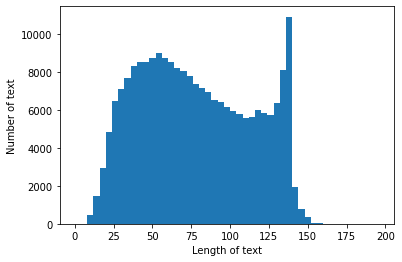

In [29]:
text_len = []

for text in dev_texts:
    text_len.append(len(text))
print(max(text_len), min(text_len), sum(text_len)/len(text_len))

bins = list(range(0, 200, 4))
plt.hist(text_len, bins=bins)

plt.xlabel("Length of text")
plt.ylabel("Number of text")
plt.savefig("Text_length_Distribution.jpg")

In [30]:
num = [0, 0, 0]
for text in dev_texts:
    if text.count('@', 0, len(text)) > 0 :
        num[0] = num[0] + 1
    if text.count('&', 0, len(text)) > 0 :
        num[1] = num[1] + 1
    if text.count('http', 0, len(text)) > 0 :
        num[2] = num[2] + 1
print(num)

[153806, 14747, 9851]


2.Processceing:


Define a text filter (regular expression matching)

In [31]:
def filter(texts):
    pat_1 = re.compile(r"(@.*?) ")
    pat_2 = re.compile(r"(&.*?[ |;])")
    pat_3 = re.compile(r"[.|,|?|!|-|*|:|$|£|¥|\\]")
    new_texts = []
    for text in texts:
        text_rm = pat_1.sub("", text)
        text_rm = pat_2.sub("", text_rm)
        text_rm = pat_3.sub("", text_rm)
        text_rm = text_rm.lower()
        new_texts.append(text_rm)
    return new_texts

filter data

In [36]:
dev_texts = filter(dev_texts)
eval_texts = filter(eval_texts)

print(len(dev_labels), len(dev_texts))
print(dev_texts[:10])

224994 224994
["yes talking helps a lot going through it there's no judgment most sentences end with you know what i mean ", 'sunshine livingg itttt imma lie on the grass listening to oasis reading  burnt already', 'something for your iphone ', "couldn't get in to the after party ", 'awww is andy being mean again  now i want maccas ', "i'm getting so anxious about tomorrow help ", 'the doctors and masters are screwed then ', 'barely been used ', "hahah it can't work on livejournal ", 'ugh sorry ur sick  fresh fruit drinks  vits e c b echinacea  golden seal rest is nice']


In [37]:
pos_dev = filter(pos_dev)
neg_dev = filter(neg_dev)

For SVM -- make vocabulary

In [38]:
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

In [39]:
vocab = []
for text in dev_texts:
    text_list = text.split(" ")
    vocab.extend(text_list)

In [40]:
all_counter = Counter(vocab)
all_counter = sorted(all_counter.items(), key=lambda i: i[1], reverse=True)
print(all_counter[:10])
print(all_counter[-10:])
print(len(all_counter))

[('', 291964), ('i', 115018), ('to', 72712), ('the', 69132), ('a', 53270), ('you', 50779), ('and', 39135), ('my', 38530), ('it', 38236), ('is', 29322)]
[('savage', 1), ('dejected', 1), ('http//twitpiccom/5cnik', 1), ('bikinidnt', 1), ('ithope', 1), ('double-', 1), ('bdr', 1), ('infofrustration', 1), ('meezybby', 1), ("showerin'", 1)]
124834


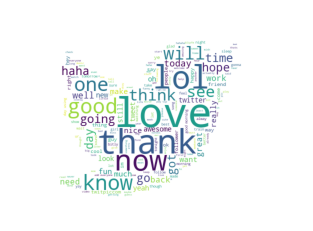

In [44]:
import wordcloud
from wordcloud import STOPWORDS
from PIL import Image

str_pos =  ''
str_pos = str_pos.join(pos_dev)


stop_words = STOPWORDS.update(["u", "co", "RT"])
backgroud = np.array(Image.open("twitter.jpg"))
wc = wordcloud.WordCloud(stopwords = stop_words, background_color='white', mask=backgroud)

wc.generate(str_pos)
plt.axis("off")

plt.imshow(wc)

plt.savefig("Most frequent words in twitter positive texts.png")

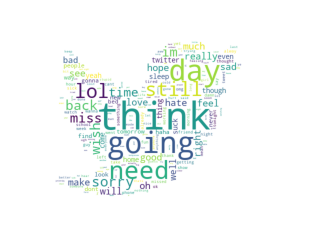

In [52]:
str_neg =  ''
str_neg = str_neg.join(neg_dev)


stop_words = STOPWORDS.update(["u", "co"])
backgroud = np.array(Image.open("twitter.jpg"))
wc = wordcloud.WordCloud(stopwords = stop_words, background_color='white', mask=backgroud)

wc.generate(str_neg)
plt.axis("off")

plt.imshow(wc)

plt.savefig("Most frequent words in twitter negative texts.png")

Filter lower word

In [10]:
vocab = [x[0] for x in all_counter if x[1]>=4]
vocab_index = {w:i for i, w in enumerate(vocab)}
print(len(vocab))
print(vocab_index["i"])

20799
1


In [11]:
vectorizer = TfidfVectorizer(vocabulary=vocab_index)
dev_X = vectorizer.fit_transform(dev_texts)
dev_y = np.array(dev_labels)
dev_X.shape, dev_y.shape

((224994, 20799), (224994,))

In [12]:
tol_list = [2e-3,1e-3,5e-4,1e-4,5e-5,1e-5,5e-6,1e-6]
for tols in tol_list:
    clf = LinearSVC(random_state=0, tol=tols)
    clf.fit(dev_X,dev_y)
    dev_acc = clf.score(dev_X, dev_y)
    print(f"acc@dev: {dev_acc:.4f}, tol: {tols}.")

acc@dev: 0.8224, tol: 0.002.
acc@dev: 0.8224, tol: 0.001.
acc@dev: 0.8224, tol: 0.0005.
acc@dev: 0.8224, tol: 0.0001.
acc@dev: 0.8224, tol: 5e-05.
acc@dev: 0.8224, tol: 1e-05.
acc@dev: 0.8224, tol: 5e-06.
acc@dev: 0.8224, tol: 1e-06.


In [19]:
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(dev_X,dev_y)
dev_acc = clf.score(dev_X, dev_y)
print(f"acc@dev: {dev_acc:.2f}.")

acc@dev: 0.82.


In [20]:
dev_pred_y = clf.predict(dev_X)
dev_f1 = f1_score(dev_y, dev_pred_y, average = 'macro')
print(f"F1@dev: {dev_f1:.2f}.")

F1@dev: 0.82.


Predict on Eval

In [21]:
eval_X = vectorizer.fit_transform(eval_texts)

In [22]:
eval_pred_y = clf.predict(eval_X)

In [23]:
result_df = pd.DataFrame(columns=['Id', 'Predicted'])
result_df['Id'] = np.arange(eval_pred_y.shape[0])
result_df['Predicted'] = eval_pred_y
print(result_df.head())

   Id  Predicted
0   0          1
1   1          1
2   2          0
3   3          1
4   4          1


Save the result

In [24]:
result_df.to_csv("svm_pred.csv", index=False)

For roBERTa: --prerocessing

In [25]:
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer

In [26]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [27]:
dev_tkids = []
for text, label in zip(dev_texts, dev_labels):
    tk_result = tokenizer(text=text)
    tid, att = tk_result.values()
    dev_tkids.append(tid)

Histogram of Sequence Length

In [28]:
tkids_lens = []
for tkids in dev_tkids:
    tkids_lens.append(len(tkids))
print(max(tkids_lens), min(tkids_lens), sum(tkids_lens)/len(tkids_lens))
    

415 2 19.089175711352304


In [30]:
over = [x for x in tkids_lens if x>50]
print(len(over))

107


In [31]:
import matplotlib.pyplot as plt

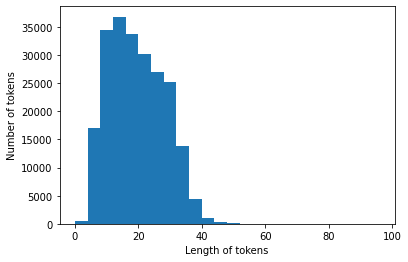

In [32]:
bins = list(range(0, 100, 4))
plt.hist(tkids_lens, bins=bins)
plt.xlabel("Length of tokens")
plt.ylabel("Number of tokens")
plt.savefig("Length_Distribution.jpg")

maxlength can be choosen as 50

In [33]:
import pickle as pkl

In [34]:
model_max_length = 50

In [35]:
dev_labels = dev.sentiment.tolist()
dev_texts = dev.text.tolist()
dev_texts = filter(dev_texts)

eval_texts = eval.text.tolist()
eval_texts = filter(eval_texts)

Process with developemnt data

In [36]:
dev_tkids, dev_atts, y = [], [], []
num_of_too_long_case = 0
for text, label in zip(dev_texts, dev_labels):
    tk_result = tokenizer(text = text, padding = "max_length")
    tid, att = tk_result['input_ids'], tk_result['attention_mask']
    if len(tid) > model_max_length:
        num_of_too_long_case +=1
        tid, att = tid[:model_max_length], att[:model_max_length]
    dev_tkids.append(tid)
    dev_atts.append(att)
    y.append(label)
print(f"{num_of_too_long_case} sentences are longer than {model_max_length} in train.")
tkids,atts, y = np.array(dev_tkids),np.array(dev_atts), np.array(y)
pkl_data = dict(tkids=tkids,atts=atts, y=y)
print(f"Processed train size: {tkids.shape}.")
with open("train_data","wb") as f:
    pkl.dump(pkl_data,f)

224994 sentences are longer than 50 in train.
Processed train size: (224994, 50).


Process with evaluation data

In [37]:
eval_tkids, eval_atts = [], []
num_of_too_long_case = 0
for text in eval_texts:
    tk_result = tokenizer(text=text,padding ="max_length")
    tid, att = tk_result['input_ids'], tk_result['attention_mask']
    if len(tid) > model_max_length:
        num_of_too_long_case += 1
        tid, att = tid[:model_max_length], att[:model_max_length]
    eval_tkids.append(tid)
    eval_atts.append(att)
print(f"{num_of_too_long_case} sentences are longer than {model_max_length} in eval.")
tkids,atts = np.array(eval_tkids),np.array(eval_atts)
pkl_data = dict(tkids=tkids, atts=atts)
print(f"Processed eval size: {tkids.shape}.")
with open("eval_data","wb") as f:
    pkl.dump(pkl_data,f)

74999 sentences are longer than 50 in eval.
Processed eval size: (74999, 50).


roBERTa----train

In [6]:
import os
import sys
import time
import random
import logging
import numpy as np
import torch

Setup random seed to avoid the impact of randomness.

In [6]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [2]:
from transformers import RobertaForSequenceClassification, RobertaConfig, RobertaTokenizer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import argparse
from sklearn.model_selection import train_test_split
import pickle as pkl

In [3]:
LR = 1e-5
WD = 0.001
EPOCH = 2
BS = 60
SD = 10
OPT = "Adam"
ML = 50
DID= 0

In [9]:
setup_seed(SD)

split into train and test data

In [10]:
with open("train_data","rb") as f:
    data = pkl.load(f)

tkids, atts, y = data["tkids"], data["atts"], data["y"]

X = np.hstack([tkids, atts])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train, X_test, y_train, y_test = np.asarray(X_train), np.asarray(X_test), np.asarray(y_train), np.asarray(y_test)
print(f"train size: {X_train.shape}, test size: {X_test.shape}")

train size: (179995, 100), test size: (44999, 100)


In [11]:
trainingDataset = TensorDataset(torch.from_numpy(X_train),torch.from_numpy(y_train))
trainingDataloader = DataLoader(trainingDataset, batch_size = BS, shuffle = True)

In [12]:
testDataset = TensorDataset(torch.from_numpy(X_test),torch.from_numpy(y_test))
testDataloader = DataLoader(testDataset,batch_size=BS,shuffle=False)

Modeling

In [13]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base")
# model.init_weights()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

Define training device

In [14]:
DEVICE = torch.device(f"cuda:{DID}" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

Define optimizer

In [15]:
if OPT == "Adam":
    optimizer = torch.optim.Adam(model.parameters(),lr=LR,weight_decay=WD)
elif OPT == "SGD":
    optimizer = torch.optim.SGD(model.parameters(),lr=LR, weight_decay=WD)
else:
    raise Exception(f"Unrecognized optimizer {OPT}.")

Start training

In [16]:
for ep in range(EPOCH):
    loss = 0
    preds, trues = [], []
    model.train()
    for i, (x,y) in enumerate(trainingDataloader):
        outputs = model(input_ids = x[:,:ML].to(DEVICE), attention_mask = x[:,ML:].to(DEVICE), labels = y.to(DEVICE))
        l = outputs.loss
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss += l.data.cpu().numpy()
        logits = outputs.logits
        probs = logits.softmax(dim=-1).data.cpu()
        _, pred = torch.max(probs, 1)
        preds.extend(pred.numpy().tolist())
        trues.extend(y.data.cpu().numpy().tolist())
        if i % 10 == 0:
            train_acc = accuracy_score(trues, preds)
            print(f"[{ep}:{i}] loss: {loss/(i+1):.4f} | acc@train: {train_acc:.4f}")
    
    model.eval()
    with torch.no_grad():
        preds, trues = [], []
        for i, (x, y) in enumerate(testDataloader):
            outputs = model(input_ids=x[:,:ML].to(DEVICE), attention_mask=x[:,ML:].to(DEVICE), labels=y.to(DEVICE))
            logits = outputs.logits
            probs = logits.softmax(dim=-1).data.cpu()
            _, pred = torch.max(probs, 1)
            preds.extend(pred.numpy().tolist())
            trues.extend(y.data.cpu().numpy().tolist())
        test_acc = accuracy_score(trues,preds)
        print(f"\n[{ep}] acc@test: {test_acc:.4f}\n")
        torch.save(model.state_dict(), "model.pkl")
    torch.cuda.empty_cache()

[0:0] loss: 0.7036 | acc@train: 0.5333
[0:10] loss: 0.6834 | acc@train: 0.5667
[0:20] loss: 0.6828 | acc@train: 0.5587
[0:30] loss: 0.6799 | acc@train: 0.5656
[0:40] loss: 0.6762 | acc@train: 0.5732
[0:50] loss: 0.6682 | acc@train: 0.5804
[0:60] loss: 0.6445 | acc@train: 0.6137
[0:70] loss: 0.6225 | acc@train: 0.6380
[0:80] loss: 0.6082 | acc@train: 0.6553
[0:90] loss: 0.5912 | acc@train: 0.6709
[0:100] loss: 0.5789 | acc@train: 0.6832
[0:110] loss: 0.5670 | acc@train: 0.6932
[0:120] loss: 0.5542 | acc@train: 0.7037
[0:130] loss: 0.5413 | acc@train: 0.7141
[0:140] loss: 0.5344 | acc@train: 0.7203
[0:150] loss: 0.5269 | acc@train: 0.7265
[0:160] loss: 0.5204 | acc@train: 0.7304
[0:170] loss: 0.5154 | acc@train: 0.7350
[0:180] loss: 0.5090 | acc@train: 0.7402
[0:190] loss: 0.5000 | acc@train: 0.7467
[0:200] loss: 0.4962 | acc@train: 0.7503
[0:210] loss: 0.4934 | acc@train: 0.7530
[0:220] loss: 0.4883 | acc@train: 0.7572
[0:230] loss: 0.4847 | acc@train: 0.7597
[0:240] loss: 0.4814 | acc@

Start predict

In [4]:
with open("eval_data","rb") as f:
    data = pkl.load(f)
tkids, atts = data["tkids"], data["atts"]
print(f"eval size: {len(tkids)}.")

eval size: 74999.


In [9]:
evalDataset = TensorDataset(torch.from_numpy(tkids),torch.from_numpy(atts))
evalDataloader = DataLoader(evalDataset, batch_size=BS, shuffle=False)

# Model
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
model.load_state_dict(torch.load('model.pkl',map_location='cpu'),strict=False)
DEVICE = torch.device(f"cuda:{DID}" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [12]:
from tqdm import tqdm
import pandas as pd
# pred 
preds = []
for i, (input_ids, attention_mask) in tqdm(enumerate(evalDataloader)):
    outputs = model(input_ids=input_ids.to(DEVICE), attention_mask=attention_mask.to(DEVICE))
    logits = outputs.logits
    probs = logits.softmax(dim=-1).data.cpu()
    _, pred = torch.max(probs, 1)
    preds.extend(pred.numpy().tolist())
print(f"Totally, {len(preds)} samples have been evaluated.")

result_df = pd.DataFrame(columns=['Id','Predicted'])
result_df['Id'] = np.arange(len(preds))
result_df['Predicted'] = preds
print(result_df.head())
result_df.to_csv("roBERTa_pred.csv",index=False)

1250it [01:17, 16.13it/s]


Totally, 74999 samples have been evaluated.
   Id  Predicted
0   0          1
1   1          1
2   2          0
3   3          1
4   4          0
